In [1]:
!uv pip install -q spacy

In [2]:
!uv pip install -q nltk gensim pyLDAvis unidecode matplotlib seaborn pandas pyarrow

In [3]:
!uv pip install -q bertopic polars datasets hf_xet

In [4]:
!uv pip install -q https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.7.0/fr_core_news_sm-3.7.0-py3-none-any.whl

In [5]:
#compaatible uniquement avec verison python 3.11 et moins et mettre la mémoire au max
!uv pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!uv pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!uv pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!uv pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

Audited 2 packages in 11ms
Audited 1 package in 14ms
Audited 1 package in 14ms
Audited 1 package in 10ms


In [6]:
!uv pip install -q langchain-huggingface==0.0.3

In [60]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from cuml.cluster import HDBSCAN
from scipy.cluster import hierarchy as sch
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from cuml.manifold import UMAP
import polars as pl
import spacy
import pandas as pd
import numpy as np
import time
from sklearn.decomposition import PCA
from langchain_huggingface import HuggingFaceEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
import tqdm as notebook_tqdm
import unidecode


In [8]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import html 
import json
import matplotlib.pyplot  as plt
import nltk
import numpy as np
import os
import pandas as pd
import unidecode
import re
import requests
import seaborn as sns
import string
import unidecode
import warnings
import torch
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/onyxia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...


True

In [9]:
stop_words = set(stopwords.words('french'))

In [10]:
class CachedLemmatizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.cache = {}  # Manual cache as a dictionary

    def lemmatize(self, word, pos='n'):
        if word in self.cache:
            return self.cache[word]
        else:
            lemmatized_word = self.lemmatizer.lemmatize(word, pos)
            self.cache[word] = lemmatized_word  # Store in cache
            return lemmatized_word


cached_lemmatizer = CachedLemmatizer()

In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [12]:
nlp = spacy.load("fr_core_news_sm")  

In [13]:
def preprocess(docs):
    cleaned = []
    for doc in nlp.pipe(docs, batch_size=100, n_process=4):
        tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
        cleaned.append(' '.join(tokens))
    return cleaned

In [103]:
DICTIONNARY =  ['accord','entreprise', 'preambule', 'sommaire',  'code', 'syndical', 'responsable', 'representant', 
                'present', 'ca', 'organisation', 'preambule', 'peut', 'etre', 'contrat','travail', 'ressources','humaines', 'mise',
                'ainsi', 'et', 'ou', 'alors','collaborateur', 'ci', 'apres', 'party', 'signataire', 'tout', 'etat', 'cause', 'societe', 
                'notamment','article','activite', 'cette', 'donc', 'si', 'sous', 'disposition', 'convention', 'collective', 'dans', 'a', 'cadre',
                'signataire', 'partie', 'parties', 'entre', 'doit', 'mme', 'mr', 'madame', 'monsieur', 'au', 'dela'
               ]

In [62]:
def preprocess_text(text, lang="french"):
    #décoage HTML
    text = html.unescape(text)
    
    #nettoyage de tous les cractères spéciaux
    text = re.sub(r"&[a-z]+;", " ", text)
    text = re.sub(r"&#\d+;", " ", text)
    text = re.sub(r"[<>{}\[\]\|\^\~`\"'=]+", " ", text)
    text = re.sub(r"[–—•«»]+", " ", text)  # Tirets longs, puces, guillemets français

    #tokenisation
    words = word_tokenize(text)

    #lemming
    #stemmer = SnowballStemmer(lang)
                  
    wnl = cached_lemmatizer
   
    words_cleaned = []
    for w in words:
        w_norm = w.lower()
        w_norm = unidecode.unidecode(w_norm)
        if (
            w_norm not in stop_words
            and w_norm not in DICTIONNARY
            and w_norm not in string.punctuation
            and not re.search(r"[<>]|--+|__+|xx+|==+", w_norm)
            and not w_norm.isnumeric()
            and len(w_norm) > 2
        ):
            words_cleaned.append(wnl.lemmatize(w_norm))
            #words_cleaned.append(stemmer.stem(w_norm))

    return words_cleaned

In [16]:
import re

def normalize(text):
    return text.lower().strip()

def split_text_by_sentences(text, flagged_sentences):
    split_texts = []
    positions = []

    normalized_text = normalize(text)

    # On garde un mapping (titre original, position) pour préserver les titres initiaux
    for sentence in flagged_sentences:
        norm_sentence = normalize(sentence)
        pos = normalized_text.find(norm_sentence)
        if pos != -1:
            # On retrouve la position réelle dans le texte original
            real_pos = text.lower().find(sentence.lower())
            if real_pos != -1:
                positions.append(real_pos)

    # Si aucune position trouvée, retourner le texte complet
    if not positions:
        return [text]

    positions = sorted(set(positions))
    positions.insert(0, 0)
    positions.append(len(text))

    for i in range(len(positions) - 1):
        start = positions[i]
        end = positions[i + 1]
        split_texts.append(text[start:end].strip())

    return split_texts



In [17]:
def split_text_with_titles(text, summary_titles):
    chunks = split_text_by_sentences(text, summary_titles)
    result = {}
    for title in summary_titles:
        for chunk in chunks:
            if normalize(title) in normalize(chunk[:len(title)+30]):
                result[title] = chunk.strip()
                break
    return result


In [18]:
model_kwargs = {'device': 'cuda'} 
#model_kwargs = {'device': 'cpu'}  
MODEL_NAME_EMBEDDER="BAAI/bge-small-en-v1.5"  #petit modèle en anglais
#MODEL_NAME_EMBEDDER="BAAI/bge-m3" #gros modèle multilingue

embedder = HuggingFaceEmbeddings(
    model_name=MODEL_NAME_EMBEDDER, 
    model_kwargs=model_kwargs,
    show_progress=True
)

phrases_non_metier = [
    "Révision de l’accord",
    "Dénonciation de l’accord",
    "Interprétation de l’accord",
    "Suivi de l’accord",
    "Durée de l’accord",
    "Formalités de publicité et de dépôt",
    "Publicité et dépôt",
    "Date d'effet et durée",
    "Champ d'application",
    "Clause de revoyure", 
    "Information des représentants du personnel", 
    "Dispositions relatives à l’accord",
    "Champ d’application",
    "Commission de suivi", 
    "Pause déjeuner du personnel", 
    "Modification de l'accord",
    "Adhésion"
    
]

# Embeddings des phrases non-métier
ref_embeddings = embedder.embed_documents(phrases_non_metier)

def filtre_par_similarite(phrases, seuil=0.85):##torp long utiliser version vectoisée
    results = []
    for phrase in phrases:
        emb = embedder.embed_query(phrase)
        sims = cosine_similarity([emb], ref_embeddings)[0]
        if max(sims) < seuil:
            results.append(phrase) 
    return results

def filtre_par_similarite_vectorise(phrases, seuil=0.85):
    if not phrases:
        return []

    phrase_embeddings = embedder.embed_documents(phrases)  
    sims = cosine_similarity(phrase_embeddings, ref_embeddings)

    # On garde les phrases dont la similarité max avec une phrase non-métier est < seuil
    keep_idx = np.max(sims, axis=1) < seuil
    return [phrase for phrase, keep in zip(phrases, keep_idx) if keep]

    
def filtre_chunks_par_titre(section_dict, phrases_non_metier, seuil=0.85): #seuil arbitraire : en tester plsr
    """
    Ne garde que les chunks dont le titre est peu similaire aux phrases non métier.
    """
    if not section_dict:
        return []

    titres = list(section_dict.keys())
    chunks = list(section_dict.values())

    # Embeddings des titres de section
    titre_embeddings = embedder.embed_documents(titres)
    ref_embeddings = embedder.embed_documents(phrases_non_metier)

    sims = cosine_similarity(titre_embeddings, ref_embeddings)

    # On garde les chunks dont le titre est peu similaire aux phrases non métier
    keep_idx = np.max(sims, axis=1) < seuil
    return [chunk.strip() for chunk, keep in zip(chunks, keep_idx) if keep]



Batches: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


In [19]:
sommaire_hs = pd.read_parquet("data/echantillon_1000_hs_accords_TOC.parquet")
df_hs = pd.read_parquet("data/echantillon_1000_hs_accords.parquet")
df_hs = df_hs.set_index("numdossier_new")
df_hs = df_hs.merge(sommaire_hs,how="inner",left_index=True,right_index=True)
df_hs = df_hs.rename(columns={"extracted_summary":"summary"})

In [20]:
df_hs["section_dict"] = df_hs.apply(
    lambda row: split_text_with_titles(row["accorddocx"], row["summary"]),
    axis=1
)

In [21]:
def get_all_chunks(section_dict):
    chunks = list(section_dict.values())
    return [chunk.strip() for chunk in chunks]

In [22]:
def get_valid_chunks_filtered(section_dict, skip_titles=["préambule", "annexe"], seuil_sim=0.85):
    skip_titles_norm = [normalize(t) for t in skip_titles]

    # supprimer le préambule et avant 
    titles = list(section_dict.keys())
    preamble_idx = next((i for i, t in enumerate(titles) if "préambule" in normalize(t)), -1)
    if preamble_idx != -1:
        titles = titles[preamble_idx + 1:]

    # garder les titres valides uniquement
    valid_titles = [
        t for t in titles if all(skip_kw not in normalize(t) for skip_kw in skip_titles_norm)
    ]
    candidate_dict = {t: section_dict[t] for t in valid_titles}

    # filtrer par similarité des titres
    return filtre_chunks_par_titre(candidate_dict, phrases_non_metier, seuil=seuil_sim)


# Modèle BERTopic 

In [23]:
df_hs["lda_documents"] = df_hs["section_dict"].apply(get_valid_chunks_filtered)

Batches: 100%|██████████| 1/1 [00:00<00:00, 67.79it/s]


In [24]:
filtered_chunks_hs = [chunk for doc_chunks in df_hs["lda_documents"] for chunk in doc_chunks]
filtered_docs = preprocess(filtered_chunks_hs)

In [25]:
#Embeddings
start = time.time()
embedding_model = SentenceTransformer("all-MiniLM-L6-v2",device='cuda')  
embeddings = embedding_model.encode(filtered_chunks_hs, show_progress_bar=True)
print(f"[1] Embedding en {time.time() - start:.2f}s")

Batches: 100%|██████████| 597/597 [00:34<00:00, 17.08it/s] 


[1] Embedding en 45.29s


In [27]:
print("Shape des embeddings :", embeddings.shape)


Shape des embeddings : (19074, 384)


In [28]:
#Réduction UMAP
start = time.time()
umap_model = UMAP(n_components=15, n_neighbors=30, random_state=42, metric="cosine", verbose=True)
#umap_model = UMAP(n_neighbors=, n_components=5, min_dist=0.0, metric='cosine', verbose=True)
umap_embeddings = umap_model.fit_transform(embeddings)
print(f"[2] UMAP en {time.time() - start:.2f}s")

[2025-05-19 08:43:54.389] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2025-05-19 08:43:54.584] [CUML] [debug] Computing KNN Graph
[2025-05-19 08:43:54.797] [CUML] [debug] Computing fuzzy simplicial set
[2] UMAP en 1.39s


In [ ]:
#umap_embeddings_filtered.shape

In [29]:
# Clustering 
start = time.time()
#hdbscan_model =  HDBSCAN(min_cluster_size=80, metric='euclidean', cluster_selection_method='eom', prediction_data=True, verbose=True)
hdbscan_model =  HDBSCAN(min_cluster_size=80, metric='euclidean', cluster_selection_method='eom', prediction_data=True, verbose=True)

clusters = hdbscan_model.fit_predict(umap_embeddings)
print(f"[3] HDBSCAN en {time.time() - start:.2f}s")
print(f"[3] Nombre de clusters trouvés : {len(np.unique(clusters))}")

[3] HDBSCAN en 0.57s
[3] Nombre de clusters trouvés : 33


In [55]:
start = time.time()
topic_model = BERTopic(
    language="french",
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)
topics, probs = topic_model.fit_transform(filtered_docs)
print(f"[4] BERTopic final en {time.time() - start:.2f}s")


2025-05-19 08:59:44,160 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 597/597 [00:26<00:00, 22.86it/s] 
2025-05-19 09:00:10,797 - BERTopic - Embedding - Completed ✓
2025-05-19 09:00:10,798 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-19 09:00:11,540 - BERTopic - Dimensionality - Completed ✓
2025-05-19 09:00:11,543 - BERTopic - Cluster - Start clustering the reduced embeddings


[2025-05-19 09:00:10.813] [CUML] [debug] Computing KNN Graph
[2025-05-19 09:00:10.902] [CUML] [debug] Computing fuzzy simplicial set
[2025-05-19 09:00:11.396] [CUML] [debug] Running transform
[2025-05-19 09:00:11.396] [CUML] [debug] Building KNN Graph
[2025-05-19 09:00:11.494] [CUML] [debug] Smoothing KNN distances
[2025-05-19 09:00:11.495] [CUML] [debug] Executing fuzzy simplicial set
[2025-05-19 09:00:11.496] [CUML] [debug] Performing L1 normalization
[2025-05-19 09:00:11.504] [CUML] [debug] n_epochs=30
[2025-05-19 09:00:11.507] [CUML] [debug] Computing # of epochs for training each sample
[2025-05-19 09:00:11.507] [CUML] [debug] Performing optimization


2025-05-19 09:00:12,072 - BERTopic - Cluster - Completed ✓
2025-05-19 09:00:12,080 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-19 09:00:13,221 - BERTopic - Representation - Completed ✓


[4] BERTopic final en 29.47s


In [88]:
cleaned_docs = [preprocess_text(doc) for doc in filtered_docs]

In [89]:
final_cleaned_docs = []
for doc in cleaned_docs: 
    TEXT=" ".join(doc)
    final_cleaned_docs.append(TEXT)

In [90]:
final_cleaned_docs

['champ application beneficiaire concerner ensemble etablissement hadvr concerner salarier cdd cdi duree metier ailleurs repondre aspiration salarier part contraindre inherent had accorder poursuivre negociation long annee vue conclusion eventuel amenagement temp sein structure',
 'remuneration temp',
 'prime partage valeur investissement materiel humain realiser cours annee repondre besoin structure investissement consequence budget non equilibre conseil administration structure conscient effort professionnel poursuivre montee charge nombre patient accueillir had repondre favorablement versement prime partage valeur euro ensemble personnel direction condition enoncer beneficier exoneration cotisation social impot revenu eligible personnel date versement prime fevrier lier apprentissage travailleurs handicape lier soutien aide esat interimaire remuneration brut inferieur smic conformement legal cours mois preceder date versement prime salaire annuel brut entendre remuneration annuel br

In [91]:
cleaned_docs

[['champ',
  'application',
  'beneficiaire',
  'concerner',
  'ensemble',
  'etablissement',
  'hadvr',
  'concerner',
  'salarier',
  'cdd',
  'cdi',
  'duree',
  'metier',
  'ailleurs',
  'repondre',
  'aspiration',
  'salarier',
  'part',
  'contraindre',
  'inherent',
  'had',
  'accorder',
  'poursuivre',
  'negociation',
  'long',
  'annee',
  'vue',
  'conclusion',
  'eventuel',
  'amenagement',
  'temp',
  'sein',
  'structure'],
 ['remuneration', 'temp'],
 ['prime',
  'partage',
  'valeur',
  'investissement',
  'materiel',
  'humain',
  'realiser',
  'cours',
  'annee',
  'repondre',
  'besoin',
  'structure',
  'investissement',
  'consequence',
  'budget',
  'non',
  'equilibre',
  'conseil',
  'administration',
  'structure',
  'conscient',
  'effort',
  'professionnel',
  'poursuivre',
  'montee',
  'charge',
  'nombre',
  'patient',
  'accueillir',
  'had',
  'repondre',
  'favorablement',
  'versement',
  'prime',
  'partage',
  'valeur',
  'euro',
  'ensemble',
  'per

In [92]:
final_cleaned_docs

['champ application beneficiaire concerner ensemble etablissement hadvr concerner salarier cdd cdi duree metier ailleurs repondre aspiration salarier part contraindre inherent had accorder poursuivre negociation long annee vue conclusion eventuel amenagement temp sein structure',
 'remuneration temp',
 'prime partage valeur investissement materiel humain realiser cours annee repondre besoin structure investissement consequence budget non equilibre conseil administration structure conscient effort professionnel poursuivre montee charge nombre patient accueillir had repondre favorablement versement prime partage valeur euro ensemble personnel direction condition enoncer beneficier exoneration cotisation social impot revenu eligible personnel date versement prime fevrier lier apprentissage travailleurs handicape lier soutien aide esat interimaire remuneration brut inferieur smic conformement legal cours mois preceder date versement prime salaire annuel brut entendre remuneration annuel br

In [72]:
#filtered_docs

In [104]:
topic_model.update_topics(final_cleaned_docs, topics=topics)

2025-05-19 09:31:15,359 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [109]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11006,-1_heure_temp_salarie_jour,"[heure, temp, salarie, jour, duree, periode, r...",[article 3.2 2 principe temps partiel moduler ...
1,0,2425,0_supplementaire_heure_jour_repos,"[supplementaire, heure, jour, repos, conge, an...",[article 4 solde fin période référence heure s...
2,1,948,1_remuneration_absence_periode_base,"[remuneration, absence, periode, base, salarie...",[b incidence absence cours période \n\n cas pé...
3,2,764,2_chapitre_jour_forfait_duree,"[chapitre, jour, forfait, duree, definition, t...","[article 2, article 4, article 5]"
4,3,563,3_revision_denonciation_lettre_denoncer,"[revision, denonciation, lettre, denoncer, rec...",[denonciation revision \n\n présent accord pou...
5,4,414,4_temp_pause_effectif_vaquer,"[temp, pause, effectif, vaquer, occupation, tr...",[3.1 durée effectif travail \n application cod...
6,5,352,5_exemplaire_depot_deposer_prud,"[exemplaire, depot, deposer, prud, conseil, ve...",[article 7 dépôt publicité accord \n présent a...
7,6,290,6_temp_amenagement_partiel_effectif,"[temp, amenagement, partiel, effectif, definit...",[article 5 aménagement temps travail temps par...
8,7,260,7_vigueur_indetermine_conclure_entree,"[vigueur, indetermine, conclure, entree, duree...",[4 1 durée entrée vigueur accord \n\n présen...
9,8,254,8_deconnexion_teletravail_outil_droit,"[deconnexion, teletravail, outil, droit, profe...",[article 4 droit déconnexion \n\n droit déco...


In [110]:
fig = topic_model.visualize_barchart()
fig.write_html("barchart_topics_bis.html")

In [111]:
fig = topic_model.visualize_topics()
fig.write_html("visualize_topics_bis.html")

# Modèle sur le topic principal 

* On veut rediviser le topic 0
* Pas mal de topic qui sont du bruit

--> Relancer un Bertopic sur le topic 0 uniquement

In [148]:
# Topic principal est le topic 0
#topics_id = [0, 1, 2]
topic_id = 0

# 1. Récupérer les indices des documents de ce topic
docs = topic_model.get_document_info(final_cleaned_docs)
#docs_in_big_topic = docs[docs['Topic'].isin(topics_id)]
docs_in_big_topic = docs[docs['Topic']== topic_id]

# 2. Extraire les textes concernés
sub_docs = docs_in_big_topic['Document'].tolist()

# 3. Recalculer les embeddings (si tu veux affiner)
sub_embeddings = embedding_model.encode(sub_docs, show_progress_bar=True)

#Réduction UMAP
start = time.time()
umap_model_sub = UMAP(n_components=15, n_neighbors=20, random_state=42, metric="cosine", verbose=True)
#umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', verbose=True)
umap_embeddings_filtered_sub = umap_model_sub.fit_transform(sub_embeddings)
print(f"[2] UMAP en {time.time() - start:.2f}s")


# Clustering 
start = time.time()
#hdbscan_model =  HDBSCAN(min_cluster_size=80, metric='euclidean', cluster_selection_method='eom', prediction_data=True, verbose=True)
hdbscan_model_sub =  HDBSCAN(min_cluster_size=100, metric='euclidean', cluster_selection_method='eom', prediction_data=True, verbose=True)
sub_clusters = hdbscan_model_sub.fit_predict(umap_embeddings_filtered_sub)
print(f"[3] HDBSCAN en {time.time() - start:.2f}s")
print(f"[3] Nombre de clusters trouvés : {len(np.unique(sub_clusters))}")

# 4. Créer un nouveau BERTopic sur ces sous-documents

sub_model = BERTopic(
    language="french",
    embedding_model=embedding_model,
    umap_model=umap_model_sub,
    hdbscan_model=hdbscan_model_sub,
    verbose=True
)

sub_model.fit(sub_docs, embeddings=sub_embeddings)



Batches: 100%|██████████| 76/76 [00:04<00:00, 18.36it/s]


[2025-05-19 09:57:02.717] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2025-05-19 09:57:02.720] [CUML] [debug] Computing KNN Graph
[2025-05-19 09:57:02.722] [CUML] [debug] Computing fuzzy simplicial set
[2] UMAP en 0.15s


2025-05-19 09:57:02,928 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-19 09:57:03,075 - BERTopic - Dimensionality - Completed ✓
2025-05-19 09:57:03,077 - BERTopic - Cluster - Start clustering the reduced embeddings


[3] HDBSCAN en 0.06s
[3] Nombre de clusters trouvés : 4
[2025-05-19 09:57:02.931] [CUML] [debug] Computing KNN Graph
[2025-05-19 09:57:02.933] [CUML] [debug] Computing fuzzy simplicial set
[2025-05-19 09:57:03.061] [CUML] [debug] Running transform
[2025-05-19 09:57:03.061] [CUML] [debug] Building KNN Graph
[2025-05-19 09:57:03.063] [CUML] [debug] Smoothing KNN distances
[2025-05-19 09:57:03.063] [CUML] [debug] Executing fuzzy simplicial set
[2025-05-19 09:57:03.064] [CUML] [debug] Performing L1 normalization
[2025-05-19 09:57:03.064] [CUML] [debug] n_epochs=100
[2025-05-19 09:57:03.064] [CUML] [debug] Computing # of epochs for training each sample
[2025-05-19 09:57:03.064] [CUML] [debug] Performing optimization


2025-05-19 09:57:03,148 - BERTopic - Cluster - Completed ✓
2025-05-19 09:57:03,152 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-19 09:57:03,294 - BERTopic - Representation - Completed ✓


In [149]:
# 5. Visualiser les nouveaux sous-topics
sub_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,998,-1_heure_supplementaire_jour_repos,"[heure, supplementaire, jour, repos, salarie, ...",[fixation contingent heure supplementaire comp...
1,0,665,0_heure_supplementaire_repos_salarie,"[heure, supplementaire, repos, salarie, effect...",[10.7 heure supplementaire continger annuel he...
2,1,425,1_jour_nombre_annee_repos,"[jour, nombre, annee, repos, salarie, travaill...",[plafond annuel jour travailles nombre maximum...
3,2,236,2_contingent_heure_supplementaire_annuel,"[contingent, heure, supplementaire, annuel, fi...",[contingent annuel heure supplementaire augmen...
4,3,101,3_conge_payer_periode_premier,"[conge, payer, periode, premier, annee, mai, p...",[periode prise conge payer conge payer acqueri...


In [150]:
fig_sub = sub_model.visualize_barchart()
fig_sub.write_html("sub_visualize_barchart.html")

# KeyBERTInspired

In [159]:
representation_model = KeyBERTInspired()

topic_model_KeyBERTInspired = BERTopic(representation_model=representation_model,
                                       embedding_model=embedding_model,
                                       umap_model=umap_model,
                                       hdbscan_model=hdbscan_model,
                                       verbose=True,
                                       language="french")
topics_KeyBERTInspired, probs_KeyBERTInspired = topic_model_KeyBERTInspired.fit_transform(filtered_docs)
topic_model_KeyBERTInspired.update_topics(final_cleaned_docs, topics=topics)

2025-05-19 10:00:22,557 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 597/597 [00:27<00:00, 21.97it/s] 
2025-05-19 10:00:50,259 - BERTopic - Embedding - Completed ✓
2025-05-19 10:00:50,260 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-19 10:00:51,035 - BERTopic - Dimensionality - Completed ✓
2025-05-19 10:00:51,038 - BERTopic - Cluster - Start clustering the reduced embeddings


[2025-05-19 10:00:50.275] [CUML] [debug] Computing KNN Graph
[2025-05-19 10:00:50.369] [CUML] [debug] Computing fuzzy simplicial set
[2025-05-19 10:00:50.884] [CUML] [debug] Running transform
[2025-05-19 10:00:50.884] [CUML] [debug] Building KNN Graph
[2025-05-19 10:00:50.986] [CUML] [debug] Smoothing KNN distances
[2025-05-19 10:00:50.987] [CUML] [debug] Executing fuzzy simplicial set
[2025-05-19 10:00:50.988] [CUML] [debug] Performing L1 normalization
[2025-05-19 10:00:50.997] [CUML] [debug] n_epochs=30
[2025-05-19 10:00:50.999] [CUML] [debug] Computing # of epochs for training each sample
[2025-05-19 10:00:51.000] [CUML] [debug] Performing optimization


2025-05-19 10:00:51,591 - BERTopic - Cluster - Completed ✓
2025-05-19 10:00:51,598 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-19 10:00:53,926 - BERTopic - Representation - Completed ✓
2025-05-19 10:00:54,308 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [160]:
topic_model_KeyBERTInspired.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11006,-1_heure_temp_salarie_jour,"[heure, temp, salarie, jour, duree, periode, r...",[article 3.2 2 principe temps partiel moduler ...
1,0,2425,0_supplementaire_heure_jour_repos,"[supplementaire, heure, jour, repos, conge, an...",[article 4 solde fin période référence heure s...
2,1,948,1_remuneration_absence_periode_base,"[remuneration, absence, periode, base, salarie...",[b incidence absence cours période \n\n cas pé...
3,2,764,2_chapitre_jour_forfait_duree,"[chapitre, jour, forfait, duree, definition, t...","[article 2, article 4, article 5]"
4,3,563,3_revision_denonciation_lettre_denoncer,"[revision, denonciation, lettre, denoncer, rec...",[denonciation revision \n\n présent accord pou...
5,4,414,4_temp_pause_effectif_vaquer,"[temp, pause, effectif, vaquer, occupation, tr...",[3.1 durée effectif travail \n application cod...
6,5,352,5_exemplaire_depot_deposer_prud,"[exemplaire, depot, deposer, prud, conseil, ve...",[article 7 dépôt publicité accord \n présent a...
7,6,290,6_temp_amenagement_partiel_effectif,"[temp, amenagement, partiel, effectif, definit...",[article 5 aménagement temps travail temps par...
8,7,260,7_vigueur_indetermine_conclure_entree,"[vigueur, indetermine, conclure, entree, duree...",[4 1 durée entrée vigueur accord \n\n présen...
9,8,254,8_deconnexion_teletravail_outil_droit,"[deconnexion, teletravail, outil, droit, profe...",[article 4 droit déconnexion \n\n droit déco...


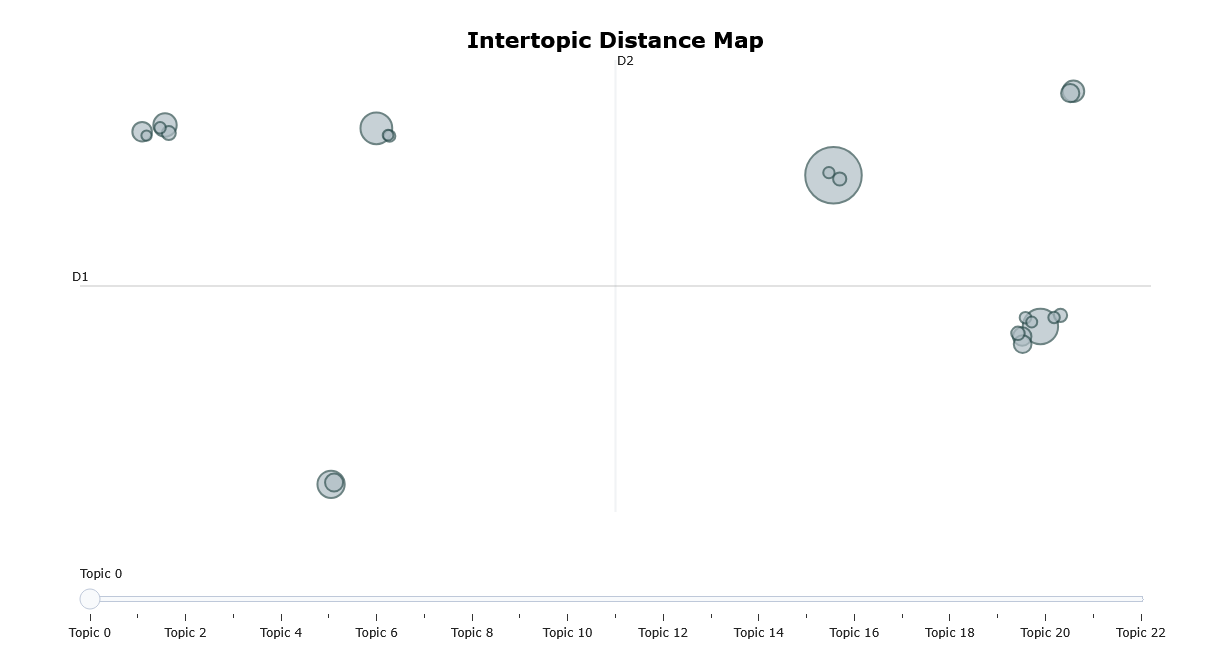

In [161]:
topic_model_KeyBERTInspired.visualize_topics()

In [162]:
topic_model_KeyBERTInspired.visualize_barchart()

# BERTopic (MMR)

In [163]:
representation_model = MaximalMarginalRelevance(diversity=0.3)

topic_model_MMR = BERTopic(representation_model=representation_model,
                                       embedding_model=embedding_model,
                                       umap_model=umap_model,
                                       hdbscan_model=hdbscan_model,
                                       verbose=True,
                                       language="french")
topics_MMR, probs_MMR = topic_model_MMR.fit_transform(filtered_docs)
topic_model_MMR.update_topics(final_cleaned_docs, topics=topics)

2025-05-19 10:01:56,204 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 597/597 [00:28<00:00, 21.21it/s] 
2025-05-19 10:02:24,894 - BERTopic - Embedding - Completed ✓
2025-05-19 10:02:24,895 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-19 10:02:25,663 - BERTopic - Dimensionality - Completed ✓
2025-05-19 10:02:25,666 - BERTopic - Cluster - Start clustering the reduced embeddings


[2025-05-19 10:02:24.909] [CUML] [debug] Computing KNN Graph
[2025-05-19 10:02:25.004] [CUML] [debug] Computing fuzzy simplicial set
[2025-05-19 10:02:25.513] [CUML] [debug] Running transform
[2025-05-19 10:02:25.513] [CUML] [debug] Building KNN Graph
[2025-05-19 10:02:25.615] [CUML] [debug] Smoothing KNN distances
[2025-05-19 10:02:25.616] [CUML] [debug] Executing fuzzy simplicial set
[2025-05-19 10:02:25.617] [CUML] [debug] Performing L1 normalization
[2025-05-19 10:02:25.626] [CUML] [debug] n_epochs=30
[2025-05-19 10:02:25.628] [CUML] [debug] Computing # of epochs for training each sample
[2025-05-19 10:02:25.629] [CUML] [debug] Performing optimization


2025-05-19 10:02:26,265 - BERTopic - Cluster - Completed ✓
2025-05-19 10:02:26,278 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-19 10:02:27,792 - BERTopic - Representation - Completed ✓
2025-05-19 10:02:28,140 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [164]:
topic_model_MMR.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11006,-1_heure_temp_salarie_jour,"[heure, temp, salarie, jour, duree, periode, r...",[article 3.2 2 principe temps partiel moduler ...
1,0,2425,0_supplementaire_heure_jour_repos,"[supplementaire, heure, jour, repos, conge, an...",[article 4 solde fin période référence heure s...
2,1,948,1_remuneration_absence_periode_base,"[remuneration, absence, periode, base, salarie...",[b incidence absence cours période \n\n cas pé...
3,2,764,2_chapitre_jour_forfait_duree,"[chapitre, jour, forfait, duree, definition, t...","[article 2, article 4, article 5]"
4,3,563,3_revision_denonciation_lettre_denoncer,"[revision, denonciation, lettre, denoncer, rec...",[denonciation revision \n\n présent accord pou...
5,4,414,4_temp_pause_effectif_vaquer,"[temp, pause, effectif, vaquer, occupation, tr...",[3.1 durée effectif travail \n application cod...
6,5,352,5_exemplaire_depot_deposer_prud,"[exemplaire, depot, deposer, prud, conseil, ve...",[article 7 dépôt publicité accord \n présent a...
7,6,290,6_temp_amenagement_partiel_effectif,"[temp, amenagement, partiel, effectif, definit...",[article 5 aménagement temps travail temps par...
8,7,260,7_vigueur_indetermine_conclure_entree,"[vigueur, indetermine, conclure, entree, duree...",[4 1 durée entrée vigueur accord \n\n présen...
9,8,254,8_deconnexion_teletravail_outil_droit,"[deconnexion, teletravail, outil, droit, profe...",[article 4 droit déconnexion \n\n droit déco...


 # Hierarchical topics 

In [165]:
hierarchical_topics = topic_model_MMR.hierarchical_topics(filtered_docs)
hierarchical_topics

100%|██████████| 22/22 [00:00<00:00, 271.96it/s]


,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
21,44,travail_article_temps_accord_disposition,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",39,accord_article_disposition_travail_signataire,43,travail_temps_article_disposition_accord,1.339455
20,43,travail_temps_article_disposition_accord,"[0, 1, 2, 4, 6, 8, 9, 10, 12, 13, 14, 15, 16, ...",40,travail_article_temps_accord_disposition,42,temps_travail_article_disposition_effectif,1.188167
19,42,temps_travail_article_disposition_effectif,"[2, 4, 6, 12, 13, 14, 19, 20, 22]",41,temps_travail_article_disposition_effectif,35,article_disposition_travail_titre_chapitre,1.150759
18,41,temps_travail_article_disposition_effectif,"[4, 6, 12, 14, 19, 20, 22]",38,travail_article_temps_disposition_contrat,28,temps_travail_article_disposition_effectif,1.029604
17,40,travail_article_temps_accord_disposition,"[0, 1, 8, 9, 10, 15, 16, 17, 21]",17,reference_periode_premier_annee_janvier,36,travail_article_temps_accord_disposition,0.926357
16,39,accord_article_disposition_travail_signataire,"[3, 5, 7, 11, 18]",11,part_siege_social_representer_immatriculer,37,accord_article_disposition_travail_signataire,0.908427
15,38,travail_article_temps_disposition_contrat,"[12, 14, 19]",19,supplementaire_heure_decompte_contrepartie_brh,32,travail_article_temps_disposition_contrat,0.875489
14,37,accord_article_disposition_travail_signataire,"[3, 5, 7, 18]",34,accord_article_disposition_travail_signataire,5,exemplaire_depot_deposer_prud_conseil,0.859863
13,36,travail_article_temps_accord_disposition,"[0, 1, 8, 9, 10, 15, 16, 21]",33,travail_article_temps_accord_disposition,29,travail_temps_article_accord_disposition,0.847752
12,35,article_disposition_travail_titre_chapitre,"[2, 13]",2,chapitre_jour_forfait_duree_definition,13,titre_final_general_generale_generales,0.754201


In [167]:
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model_MMR.hierarchical_topics(filtered_docs, linkage_function=linkage_function)

100%|██████████| 22/22 [00:00<00:00, 235.05it/s]


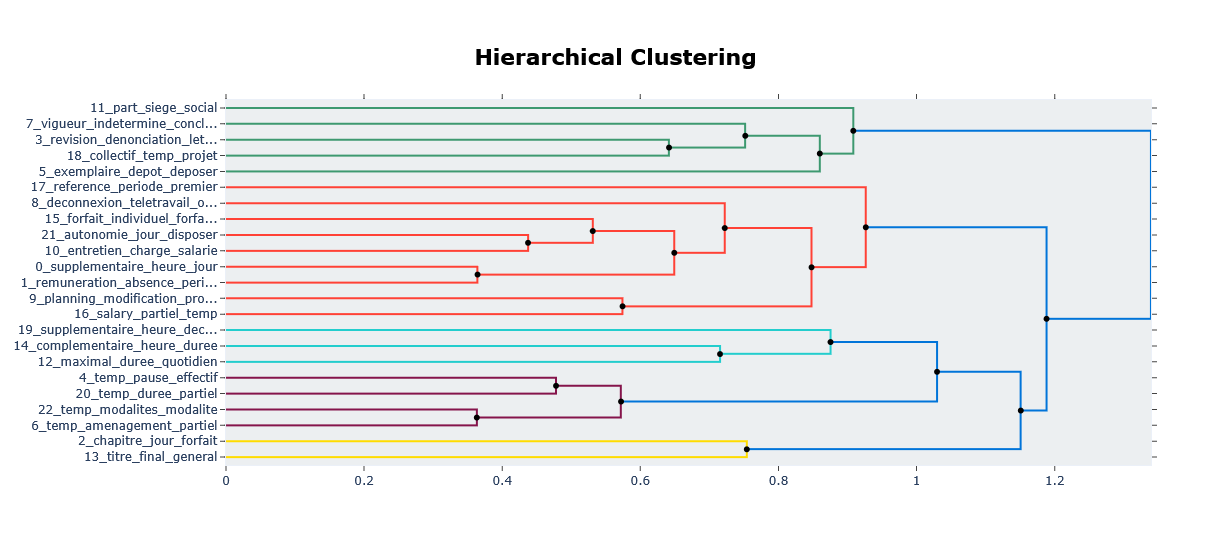

In [168]:
topic_model_MMR.visualize_hierarchy(hierarchical_topics=hierarchical_topics)